In [3]:
import os
import numpy as np
import tensorflow as tf

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')


In [11]:
print (PATH)
train_dir = os.path.join (PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
print(train_dir)
print(validation_dir)
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size = BATCH_SIZE,
    image_size=IMG_SIZE
)

/home/jupyter/.keras/datasets/cats_and_dogs_filtered
/home/jupyter/.keras/datasets/cats_and_dogs_filtered/train
/home/jupyter/.keras/datasets/cats_and_dogs_filtered/validation
Found 2000 files belonging to 2 classes.


2021-11-14 05:03:37.041033: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-14 05:03:37.045757: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 1000 files belonging to 2 classes.


In [13]:
class_names = train_dataset.class_names
print(class_names)

['cats', 'dogs']


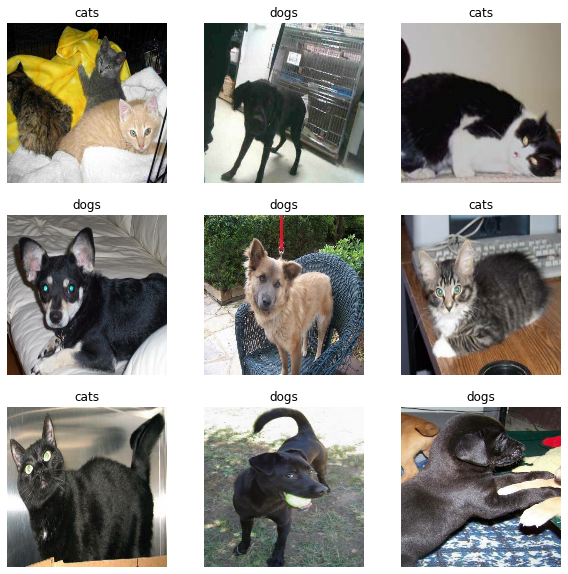

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [18]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [22]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

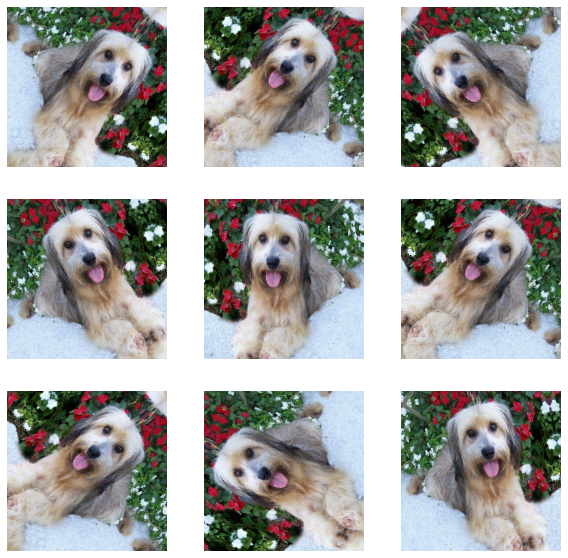

In [23]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [26]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1.0/127.5, offset=-1)

In [28]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

9420800/9406464 [==============================] - 0s 0us/step


In [29]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [30]:
base_model.trainable = False


In [39]:
#base_model.summary()

In [34]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [35]:
prediction_layer = tf.keras.layers.Dense(1)

In [37]:
prediction_batch = prediction_layer(feature_batch_average)

In [38]:
print(prediction_batch.shape)

(32, 1)


In [40]:
inputs = tf.keras.layers.Input(shape=(160,160,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)



In [41]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
    , loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
    , metrics = ['accuracy']
)

In [42]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [44]:
initial_epochs = 10
losses0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 6s 170ms/step - loss: 0.8815 - accuracy: 0.4604


In [46]:
print("initial loss: {:.2f}".format(losses0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.88
initial accuracy: 0.46


In [47]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 22s 307ms/step - loss: 0.8194 - accuracy: 0.4930 - val_loss: 0.5914 - val_accuracy: 0.6188
Epoch 2/10
63/63 [==============================] - 19s 305ms/step - loss: 0.5979 - accuracy: 0.6445 - val_loss: 0.4302 - val_accuracy: 0.7413
Epoch 3/10
63/63 [==============================] - 20s 312ms/step - loss: 0.4637 - accuracy: 0.7450 - val_loss: 0.3273 - val_accuracy: 0.8280
Epoch 4/10
63/63 [==============================] - 20s 321ms/step - loss: 0.3854 - accuracy: 0.8130 - val_loss: 0.2670 - val_accuracy: 0.8886
Epoch 5/10
63/63 [==============================] - 19s 305ms/step - loss: 0.3316 - accuracy: 0.8365 - val_loss: 0.2254 - val_accuracy: 0.9084
Epoch 6/10
63/63 [==============================] - 19s 302ms/step - loss: 0.2967 - accuracy: 0.8685 - val_loss: 0.1944 - val_accuracy: 0.9196
Epoch 7/10
63/63 [==============================] - 19s 302ms/step - loss: 0.2697 - accuracy: 0.8800 - val_loss: 0.1748 - val_accuracy: 0.9344

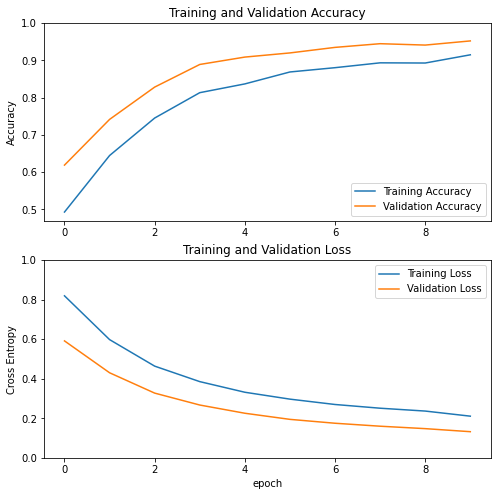

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [49]:
#Fine tune to improve performance further


In [53]:
print("Number of layers: {}".format(len(base_model.layers)))

Number of layers: 154


In [54]:
# Fine-tune from this layer onwards
fine_tune_at = 100

In [55]:
base_model.trainable = True

In [56]:
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainnable = False

In [58]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10)
    , loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
    , metrics = ['accuracy']
)

In [59]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [60]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 153s 2s/step - loss: 0.1535 - accuracy: 0.9400 - val_loss: 0.0526 - val_accuracy: 0.9814
Epoch 11/20
63/63 [==============================] - 154s 2s/step - loss: 0.1225 - accuracy: 0.9510 - val_loss: 0.0504 - val_accuracy: 0.9802
Epoch 12/20
63/63 [==============================] - 144s 2s/step - loss: 0.1082 - accuracy: 0.9535 - val_loss: 0.0792 - val_accuracy: 0.9715
Epoch 13/20
63/63 [==============================] - 141s 2s/step - loss: 0.0828 - accuracy: 0.9675 - val_loss: 0.0374 - val_accuracy: 0.9839
Epoch 14/20
63/63 [==============================] - 136s 2s/step - loss: 0.0750 - accuracy: 0.9730 - val_loss: 0.0414 - val_accuracy: 0.9839
Epoch 15/20
63/63 [==============================] - 153s 2s/step - loss: 0.0808 - accuracy: 0.9680 - val_loss: 0.0572 - val_accuracy: 0.9752
Epoch 16/20
63/63 [==============================] - 138s 2s/step - loss: 0.0640 - accuracy: 0.9770 - val_loss: 0.0572 - val_accuracy: 0.9765
Epoch 

In [61]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

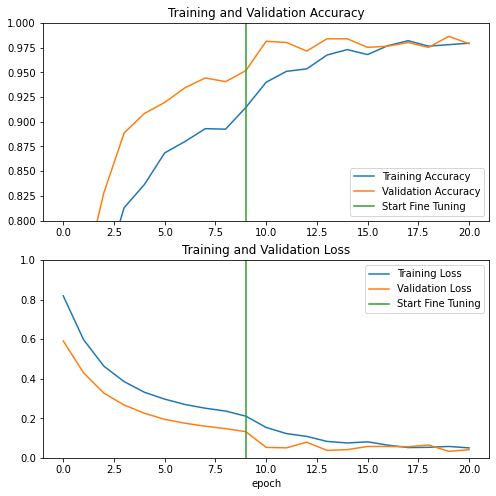

In [62]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [63]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 193ms/step - loss: 0.0140 - accuracy: 0.9948
Test accuracy : 0.9947916865348816


In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

Predictions:
 [1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1]
Labels:
 [1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1]
